## Cálculo de prazos e ciclos

In [2]:
# bibliotecas usadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
C:\Users\Madu\AppData\Local\Temp\ipykernel_19440\1410050648.py:2: SyntaxWarning: invalid escape sequence '\{'
  caminho_arquivo = 'C:\{estudos}\ADC - Embraer SA\Embraer-SA\Demonstrações_Embraer_Ajustado.xlsm'


✅ Arquivo carregado. Abas: ['Ativo', 'Passivo', 'DRE', 'DFC']

--- Indicadores de Prazos e Ciclos Calculados (em Dias) ---
      PME (Estocagem)  PMR (Recebimento)  PMP (Pagamento)  Ciclo Operacional  \
2020            291.0               22.1             59.8              313.2   
2021            218.9               18.5             56.2              237.3   
2022            243.1               21.2             80.1              264.3   
2023            211.8               15.0             66.3              226.9   
2024            225.4               21.0             77.5              246.3   

      Ciclo Financeiro  
2020             253.4  
2021             181.1  
2022             184.2  
2023             160.6  
2024             168.8  

✅ Tabela salva em 'Prazos_e_Ciclos_Embraer.xlsx'


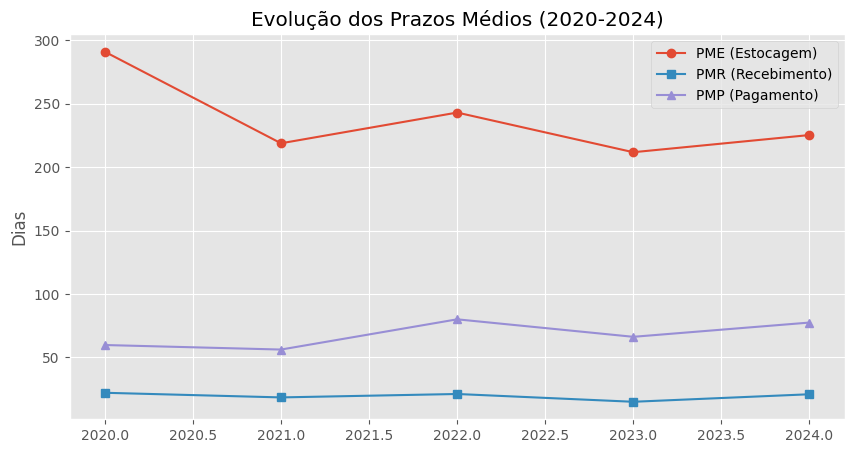

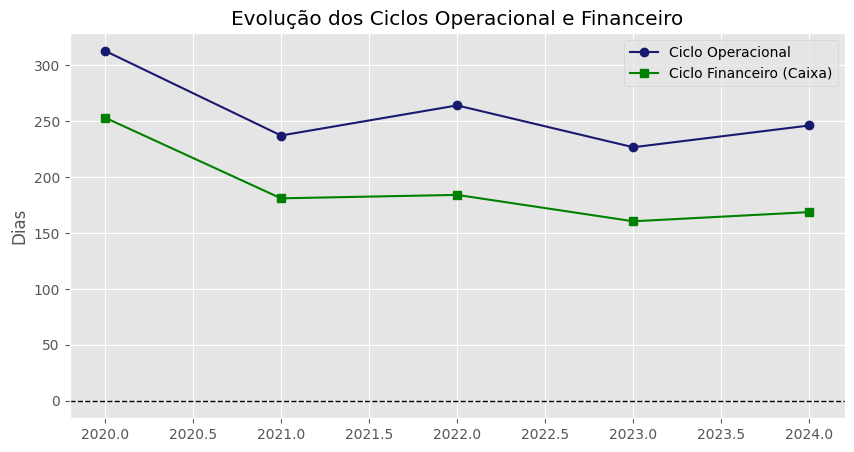

✅ Gráficos gerados e salvos como imagens PNG.


In [4]:


# --- 1. CARREGAR DADOS BRUTOS ---
caminho_arquivo = 'C:\{estudos}\ADC - Embraer SA\Embraer-SA\Demonstrações_Embraer_Ajustado.xlsm'

try:
    # Carrega as abas necessárias
    xlsx = pd.read_excel(caminho_arquivo, sheet_name=None)
    df_ativo = xlsx['Ativo']
    df_passivo = xlsx['Passivo']
    df_dre = xlsx['DRE']
    print(f"✅ Arquivo carregado. Abas: {list(xlsx.keys())}")
except FileNotFoundError:
    print(f"❌ Arquivo '{caminho_arquivo}' não encontrado. Verifique o nome.")
    # Pare a execução se não tiver o arquivo
    exit()

# --- 2. EXTRAÇÃO DAS CONTAS (Mapeamento) ---
# Função auxiliar para pegar a linha pelo código
def pegar_valor(df, codigo):
    # Tenta encontrar a coluna de código (pode variar entre 'CD_CONTA', 'Código', etc.)
    col_cod = next((c for c in df.columns if 'CD' in c or 'Cod' in c), None)
    if not col_cod: return None
    
    # Filtra e retorna os valores dos anos (colunas numéricas)
    linha = df[df[col_cod].astype(str).str.strip() == str(codigo)]
    if linha.empty: return None
    
    colunas_anos = [c for c in df.columns if str(c).isdigit()]
    return linha[colunas_anos].iloc[0]

# Extraindo as séries temporais necessárias
# CÓDIGOS PADRÃO (Verifique se batem com seu Excel)
receita = pegar_valor(df_dre, '3.01') # Receita Líquida
cmv = pegar_valor(df_dre, '3.02')     # Custos (CMV) - geralmente negativo
estoques = pegar_valor(df_ativo, '1.01.04') # Estoques
clientes = pegar_valor(df_ativo, '1.01.03') # Contas a Receber / Clientes
fornecedores = pegar_valor(df_passivo, '2.01.02') # Fornecedores

# Ajuste de sinal do CMV (para positivo)
if cmv is not None: cmv = cmv.abs()

# Verifica se pegou tudo
if any(v is None for v in [receita, cmv, estoques, clientes, fornecedores]):
    print("⚠️ Alguma conta não foi encontrada pelo código padrão. Verifique os códigos no seu Excel.")
    # Dica: Imprima df_dre.head() para ver os códigos corretos se der erro.
else:
    # --- 3. CÁLCULO DOS INDICADORES DE ATIVIDADE ---
    indicadores = pd.DataFrame(index=receita.index) # Cria DF com os anos

    # 3.1 Prazos Médios (em Dias)
    # PME = (Estoques / CMV) * 360
    indicadores['PME (Estocagem)'] = (estoques / cmv) * 360
    
    # PMR = (Clientes / Receita) * 360
    indicadores['PMR (Recebimento)'] = (clientes / receita) * 360
    
    # Cálculo das Compras (Aprox: CMV + Est_Final - Est_Inicial)
    # Como simplificação, muitas análises usam Compras ≈ CMV. Vamos usar CMV ajustado se possível, ou apenas CMV.
    # Ajuste: Compras = CMV + Delta Estoque.
    # Para simplificar e evitar perder o primeiro ano, usaremos Compras ≈ CMV (comum em análises rápidas)
    # Ou PMP = (Fornecedores / CMV) * 360 (se não tiver compras exatas)
    indicadores['PMP (Pagamento)'] = (fornecedores / cmv) * 360 

    # 3.2 Ciclos
    # Ciclo Operacional = PME + PMR
    indicadores['Ciclo Operacional'] = indicadores['PME (Estocagem)'] + indicadores['PMR (Recebimento)']
    
    # Ciclo Financeiro = Ciclo Operacional - PMP
    indicadores['Ciclo Financeiro'] = indicadores['Ciclo Operacional'] - indicadores['PMP (Pagamento)']

    print("\n--- Indicadores de Prazos e Ciclos Calculados (em Dias) ---")
    print(indicadores.round(1))

    # --- 4. EXPORTAÇÃO E VISUALIZAÇÃO GRÁFICA ---
    
    # Salvar em Excel
    indicadores.to_excel("Prazos_e_Ciclos_Embraer.xlsx")
    print("\n✅ Tabela salva em 'Prazos_e_Ciclos_Embraer.xlsx'")

    # Plotar Gráficos de Tendência
    plt.style.use('ggplot') # Estilo visual bonito
    
    # Gráfico 1: Prazos Médios
    plt.figure(figsize=(10, 5))
    plt.plot(indicadores.index, indicadores['PME (Estocagem)'], marker='o', label='PME (Estocagem)')
    plt.plot(indicadores.index, indicadores['PMR (Recebimento)'], marker='s', label='PMR (Recebimento)')
    plt.plot(indicadores.index, indicadores['PMP (Pagamento)'], marker='^', label='PMP (Pagamento)')
    plt.title('Evolução dos Prazos Médios (2020-2024)')
    plt.ylabel('Dias')
    plt.legend()
    plt.grid(True)
    plt.savefig("Grafico_Prazos_Medios.png")
    plt.show()

    # Gráfico 2: Ciclos
    plt.figure(figsize=(10, 5))
    plt.plot(indicadores.index, indicadores['Ciclo Operacional'], marker='o', color='midnightblue', label='Ciclo Operacional')
    plt.plot(indicadores.index, indicadores['Ciclo Financeiro'], marker='s', color='green', label='Ciclo Financeiro (Caixa)')
    plt.title('Evolução dos Ciclos Operacional e Financeiro')
    plt.ylabel('Dias')
    plt.legend()
    plt.grid(True)
    
    # Adiciona linha de zero (se Ciclo Financeiro for negativo, é ótimo)
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    
    plt.savefig("Grafico_Ciclos.png")
    plt.show()

    print("✅ Gráficos gerados e salvos como imagens PNG.")